In [81]:
import gym

import itertools
import numpy as np
import matplotlib.pyplot as plt
import random

from collections import defaultdict
from tqdm import tqdm
from copy import deepcopy

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

%matplotlib inline

# Environment

In [3]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3

In [316]:
class TicTacToe(gym.Env):
    def __init__(self, n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.n_win = n_win

        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.gameOver = False
        self.boardHash = None
        # ход первого игрока
        self.curTurn = 1
        self.emptySpaces = None
        
        self.action_space = n_rows * n_cols
        self.state_space = 3 ** self.action_space
        
        self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([(i, j) for i,j in zip(res[0], res[1])])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_marks, cur_p = np.where(self.board == self.curTurn), self.curTurn
        for i,j in zip(cur_marks[0], cur_marks[1]):
#             print((i,j))
            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(self.board[i,j:j+self.n_win] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                    if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if win:
                self.gameOver = True
                return self.curTurn

        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----'*(self.n_cols)+'-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----'*(self.n_cols)+'-')

    def getState(self):
        return self.getHash(), self.getEmptySpaces(), self.curTurn

    def action_from_int(self, action_int):
        return (int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def step(self, action, from_int=False):
        if from_int:
            action = self.action_from_int(action)
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1
        return self.getState() 

In [5]:
def plot_board(env, pi, showtext=True, verbose=True, fontq=20, fontx=60):
    '''Рисуем доску с оценками из стратегии pi'''
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    X, Y = np.meshgrid(np.arange(0, env.n_rows), np.arange(0, env.n_rows))
    Z = np.zeros((env.n_rows, env.n_cols)) + .01
    s, actions = env.getHash(), env.getEmptySpaces()
    if pi is not None and s in pi.Q:
        for i, a in enumerate(actions):
            Z[a[0], a[1]] = pi.Q[s][i]
    ax.set_xticks([])
    ax.set_yticks([])
    surf = ax.imshow(Z, cmap=plt.get_cmap('Accent', 10), vmin=-1, vmax=1)
    if showtext:
        for i,a in enumerate(actions):
            if pi is not None and s in pi.Q:
                ax.text( a[1] , a[0] , "%.3f" % pi.Q[s][i], fontsize=fontq, horizontalalignment='center', verticalalignment='center', color="w" )
#             else:
#                 ax.text( a[1] , a[0] , "???", fontsize=fontq, horizontalalignment='center', verticalalignment='center', color="w" )
    for i in range(env.n_rows):
        for j in range(env.n_cols):
            if env.board[i, j] == -1:
                ax.text(j, i, "O", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
            if env.board[i, j] == 1:
                ax.text(j, i, "X", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
    cbar = plt.colorbar(surf, ticks=[0, 1])
    ax.grid(False)
    plt.show()

def get_and_print_move(env, pi, s, actions, random=False, verbose=True, fontq=20, fontx=60):
    '''Делаем ход, рисуем доску'''
    plot_board(env, pi, fontq=fontq, fontx=fontx)
    if verbose and (pi is not None):
        if s in pi.Q:
            for i,a in enumerate(actions):
                print(i, a, pi.Q[s][i])
        else:
            print("Стратегия не знает, что делать...")
    if random:
        return np.random.randint(len(actions))
    else:
        return pi.getActionGreedy(s, len(actions))
    
def plot_test_game(env, pi1, pi2, random_crosses=False, random_naughts=True, verbose=True, fontq=20, fontx=60):
    '''Играем тестовую партию между стратегиями или со случайными ходами, рисуем ход игры'''
    done = False
    env.reset()
    while not done:
        s, actions = env.getHash(), env.getEmptySpaces()
        if env.curTurn == 1:
            a = get_and_print_move(env, pi1, s, actions, random=random_crosses, verbose=verbose, fontq=fontq, fontx=fontx)
        else:
            a = get_and_print_move(env, pi2, s, actions, random=random_naughts, verbose=verbose, fontq=fontq, fontx=fontx)
        observation, reward, done, info = env.step(actions[a])
        if reward == 1:
            print("Крестики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)
        if reward == -1:
            print("Нолики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)

# Часть первая: крестики-нолики при помощи Q-обучения

В коде, прилагающемся к последней лекции про обучение с подкреплением, реализован Environment для крестиков-ноликов, в котором можно при инициализации указывать разные размеры доски и условия победы, а также функции для рисования, в том числе с указанием оценки различных действий. С этим окружением все задания и связаны.
- Реализуйте обычное (табличное) Q-обучение. Обучите стратегии крестиков и ноликов для доски 3х3.
- Попробуйте обучить стратегии крестиков и ноликов для доски 4х4 и/или 5х5.

Disclaimer: начиная с пункта 2, задания для досок размера больше 4х4 могут потребовать большого терпения или более сложных вычислительных реализаций (например, параллелизации). Не хочу в этом задании непременно требовать ни того ни другого, так что если не будет получаться доучить до победных стратегий, не страшно -- но покажите, что со временем что-то всё-таки улучшается.

In [6]:
def evaluate_pi(Q):
    return Q.argmax()

def play_by_pi(Q, env, n_episodes=500_000, crosses=True):
    # играем против случайной стратегии
    wins = 0
    losses = 0
    draws = 0
    rewards = []
    for _ in range(n_episodes):
        s, empty_spaces, cur_turn = env.reset()
        done = False
        while not done:
            # мы играем за тех, чей ход
            if ((cur_turn == 1 and crosses) or (cur_turn == -1 and not crosses)) and (s in Q):
                a_idx = evaluate_pi(Q[s])
            else:
                a_idx = np.random.randint(len(empty_spaces))
            a = empty_spaces[a_idx]
            next_state, r, done, _ = env.step(a) 
            s, empty_spaces, cur_turn = next_state
        
        if r == -10: # только мы сами могли так плохо сходить
            raise ValueError('Impossible!')
        elif r == 0:
            reward = r
            draws += 1
        else:
            reward = r if crosses else -r
            if reward == 1:
                wins += 1
            else:
                losses += 1

        rewards.append(reward)
    return rewards, wins, losses, draws

def q_learning(Q, env, alpha=0.01, gamma=1, epsilon=0.01):
    s, empty_spaces, cur_turn = env.reset()
    done = False
    crosses_moves = []
    noughts_moves = []
    while not done: 
        if s in Q:
            a_idx = evaluate_pi(Q[s]) if np.random.rand() > epsilon else np.random.randint(len(empty_spaces))
        else:
            a_idx = np.random.randint(len(empty_spaces))
            Q[s] = np.zeros(len(empty_spaces))
        a = empty_spaces[a_idx]
        next_state, r, done, _ = env.step(a)
        if cur_turn == 1:
            crosses_moves.append((s, a_idx))
        else:
            noughts_moves.append((s, a_idx))
        s, empty_spaces, cur_turn = next_state
    
    last_crosses_move, last_crosses_action = crosses_moves[-1]
    last_noughts_move, last_noughts_action = noughts_moves[-1]
    if r == -10:
        raise ValueError('Impossible!')
    else:
        Q[last_crosses_move][last_crosses_action] = r
        Q[last_noughts_move][last_noughts_action] = -r
    next_maxQ_crosses = np.max(Q[last_crosses_move])
    next_maxQ_noughts = np.max(Q[last_noughts_move])
    
    for s, a_idx in reversed(crosses_moves[:-1]):
        Q[s][a_idx] = Q[s][a_idx] + alpha * (gamma * next_maxQ_crosses - Q[s][a_idx])
        next_maxQ_crosses = np.max(Q[s])
        
    for s, a_idx in reversed(noughts_moves[:-1]):
        Q[s][a_idx] = Q[s][a_idx] + alpha * (gamma * next_maxQ_noughts - Q[s][a_idx])
        next_maxQ_noughts = np.max(Q[s])
        
    return Q
        
def evaluate_reward(Q, env, alpha, epsilon, gamma, n_episodes_train=500_000, n_episodes_eval=500_000,
                    eval_every=20_000):
    rewards = []
    for i in tqdm(range(n_episodes_train)):
        if i == 0 or (i + 1) % eval_every == 0:
            rewards_c, wins_c, losses_c, draws_c = play_by_pi(Q, env, n_episodes=n_episodes_eval)
            rewards_n, wins_n, losses_n, draws_n = play_by_pi(Q, env, n_episodes=n_episodes_eval, crosses=False)
            rewards.append((np.mean(rewards_c), np.mean(rewards_n)))
        Q = q_learning(Q, env, alpha=alpha, gamma=gamma, epsilon=epsilon)
    return rewards, Q

Обучим для 3x3, при обучении будем играть сами с собой, а при тестировании - со случайной стратегией. Обучать будем только на "легальных" ходах, соответсвенно, нам не придется учить агента не делать "невозможные" ходы.

In [317]:
env33 = TicTacToe(n_rows=3, n_cols=3, n_win=3)
Q33 = dict()

In [7]:
rewards33, Q33 = evaluate_reward(Q33, env33, 0.01, 0.3, 1, n_episodes_train=300_000, n_episodes_eval=1000,
                                 eval_every=1000)

rewards33 = np.array(rewards33)

100%|██████████| 300000/300000 [09:40<00:00, 516.47it/s] 


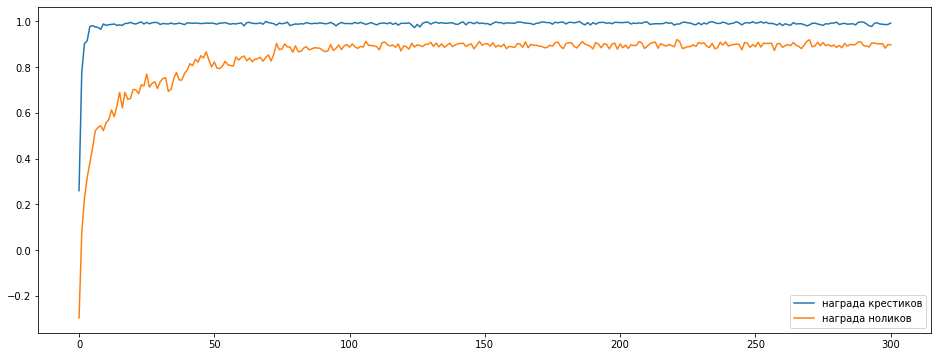

In [8]:
plt.figure(figsize=(16, 6))
plt.plot(rewards33[:, 0], label='награда крестиков')
plt.plot(rewards33[:, 1], label='награда ноликов')
plt.legend();

Как мы видим, удалось обучить довольно хорошие стратегии. Попробуем для 4x4.

In [8]:
env44 = TicTacToe(n_rows=4, n_cols=4, n_win=4)
Q44 = dict()

In [7]:
rewards44, Q44 = evaluate_reward(Q44, env44, 0.01, 0.3, 1, n_episodes_train=2_000_000, n_episodes_eval=1000,
                                 eval_every=10000)

rewards44 = np.array(rewards44)

100%|██████████| 2000000/2000000 [1:13:24<00:00, 454.05it/s] 


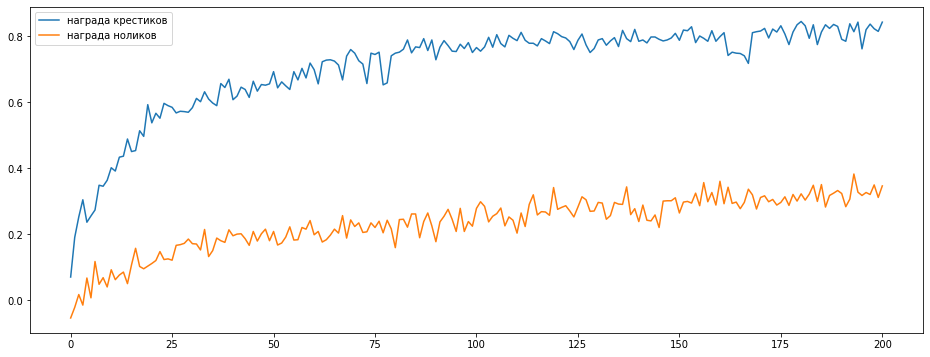

In [8]:
plt.figure(figsize=(16, 6))
plt.plot(rewards44[:, 0], label='награда крестиков')
plt.plot(rewards44[:, 1], label='награда ноликов')
plt.legend();

4x4 обучились похуже, хоть и обучались сильно дольше. Очевидно, дело в большом количестве состояний. Видно, что можно было доучивать и дальше.

# Часть вторая: добавим нейронных сетей

Реализуйте нейронную сеть для метода DQN на доске для крестиков-ноликов. Не буду ограничивать фантазию, но кажется, что свёртки 3х3 здесь должны неплохо работать (в том числе обобщаться на доски размера побольше).
- Реализуйте DQN с нейронной сетью, обучите стратегии крестиков и ноликов. Замечание: скорее всего, experience replay потребуется сразу же.
- Реализуйте Double DQN и/или Dueling DQN.

In [388]:
class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def store(self, exptuple):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = exptuple
        self.position = (self.position + 1) % self.capacity
       
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)
    
class Network33(nn.Module):
    def __init__(self, layer_size=512):
        super().__init__()
        self.l1 = nn.Conv2d(3, layer_size, 3)
        self.l2 = nn.Linear(layer_size, layer_size)
        self.l3 = nn.Linear(layer_size, 9)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.l2(x))
        x = self.l3(x)
        return x
    
class Network44(nn.Module):
    def __init__(self, layer_size=512):
        super().__init__()
        self.l1 = nn.Conv2d(3, layer_size, 3)
        self.l2 = nn.Linear(layer_size * 4, layer_size)
        self.l3 = nn.Linear(layer_size, 16)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.l2(x))
        x = self.l3(x)
        return x
      
class DQN:
    def __init__(self, env, network, batch_size=256, lr=1e-5, gamma=0.8, eps_init=0.9, eps_final=0.25, 
                 eps_decay=50000, weight_decay=1e-5):
        self.env = env
        self.model = {1: network(), -1: network()}
        self.memory = {1: ReplayMemory(10000), -1: ReplayMemory(10000)}
        self.optimizer = {1: optim.Adam(self.model[1].parameters(), lr, weight_decay=weight_decay), 
                          -1: optim.Adam(self.model[-1].parameters(), lr, weight_decay=weight_decay)}
        self.steps_done = 0
        self.episode_durations = []
        
        self.gamma = gamma
        self.batch_size = batch_size
        
        self.eps_init, self.eps_final, self.eps_decay = eps_init, eps_final, eps_decay
        self.num_step = 0

    def select_greedy_action(self, state, cur_turn):
        q = self.model[cur_turn](state.unsqueeze(0)).squeeze(0)
        return int(q.argmax())
    
    def board_to_tensor(self, board):
        board = np.array(list(map(np.int32, board))).reshape(self.env.n_rows, self.env.n_cols)
        board = np.stack([(board == 2).astype(np.int32),
                          (board == 0).astype(np.int32),
                          (board == 1).astype(np.int32)])
        return torch.FloatTensor(board)
    
    def get_legal_actions(self, empty_spaces):
        return np.array([self.env.int_from_action(a) for a in empty_spaces])

    def select_action(self, state, cur_turn, empty_spaces=None):
        sample = random.random()
        eps_threshold = self.eps_final + (self.eps_init - self.eps_final) * np.exp(-self.num_step / self.eps_decay)
        if sample > eps_threshold:
            return self.select_greedy_action(state, cur_turn)
        else:
            if empty_spaces is not None:
                legal_a_idx = self.get_legal_actions(empty_spaces)
                return np.random.choice(legal_a_idx)
            return np.random.randint(self.env.action_space)
        
    def run_episode(self, do_learning=True, greedy=False):
        states = {1: [], -1: []}
        actions = {1: [], -1: []}
        s, empty_spaces, cur_turn = self.env.reset()
        done = False
        self.model[1].eval()
        self.model[-1].eval()
        while not done:
            with torch.no_grad():
                s_tensor = self.board_to_tensor(s)
                
                if greedy:
                    a_idx = self.select_greedy_action(s_tensor, cur_turn)
                else:
                    a_idx = self.select_action(s_tensor, cur_turn, empty_spaces)
                
                action = self.env.action_from_int(a_idx)
                next_state, r, done, _ = self.env.step(action)
                next_s, empty_spaces, next_turn = next_state
                next_s_tensor = self.board_to_tensor(next_s)
                
                if states[cur_turn]:
                    transition = (states[cur_turn][-1], actions[cur_turn][-1], 
                                  s_tensor, torch.tensor([0], dtype=torch.float32))
                    self.memory[cur_turn].store(transition)
                
                if done:
                    break

                states[cur_turn].append(s_tensor)
                actions[cur_turn].append(torch.tensor([a_idx], dtype=torch.long))
            
                s = next_s
                cur_turn = next_turn                
                
        if r == -10:
            transition = (s_tensor, torch.tensor([a_idx], dtype=torch.long), 
                          next_s_tensor, torch.tensor([r], dtype=torch.float32))
            self.memory[cur_turn].store(transition) # запишем себе
        else:
            transition = (s_tensor, torch.tensor([a_idx], dtype=torch.long), 
                          next_s_tensor, torch.tensor([cur_turn * r], dtype=torch.float32))
            self.memory[cur_turn].store(transition) # запишем себе
            
            transition = (states[-cur_turn][-1], actions[-cur_turn][-1], 
                          next_s_tensor, torch.tensor([-cur_turn * r], dtype=torch.float32))
            self.memory[-cur_turn].store(transition) # запишем сопернику
          
        self.num_step += 1
        
        if do_learning:
            self.learn(cur_turn)

    def learn(self, cur_turn):
        if len(self.memory[cur_turn]) < self.batch_size:
            return
        
        self.model[1].train()
        self.model[-1].train()

        # берём мини-батч из памяти
        transitions = self.memory[cur_turn].sample(self.batch_size)
        batch_state, batch_action, batch_next_state, batch_reward = zip(*transitions)
        
        batch_state = torch.stack(batch_state)
        batch_action = torch.stack(batch_action)
        batch_reward = torch.cat(batch_reward)
        batch_next_state = torch.stack(batch_next_state)

        # считаем значения функции Q
        Q = self.model[cur_turn](batch_state).gather(1, batch_action).reshape([self.batch_size])
        
        # оцениваем ожидаемые значения после этого действия
        Qmax = self.model[cur_turn](batch_next_state).detach().max(1)[0]
        Qnext = batch_reward + (self.gamma * Qmax)

        # и хотим, чтобы Q было похоже на Qnext -- это и есть суть Q-обучения
        loss = F.smooth_l1_loss(Q, Qnext)
        
        self.optimizer[cur_turn].zero_grad()
        loss.backward()
        self.optimizer[cur_turn].step()
        
    def evaluate(self, n_episodes=1000, crosses=True):
        # играем против случайной стратегии
        wins = 0
        losses = 0
        draws = 0
        rewards = []
        for _ in range(n_episodes):
            s, empty_spaces, cur_turn = self.env.reset()
            done = False
            while not done:
                s_tensor = self.board_to_tensor(s)
                
                if ((cur_turn == 1 and crosses) or (cur_turn == -1 and not crosses)):
                    a_idx = self.select_greedy_action(s_tensor, cur_turn)
                    a = self.env.action_from_int(a_idx)
                else:
                    a_idx = np.random.randint(len(empty_spaces))
                    a = empty_spaces[a_idx]

                next_state, r, done, _ = self.env.step(a) 
                s, empty_spaces, cur_turn = next_state

            if r == -10: # только мы могли так плохо сходить
                reward = -1
                losses += 1
            elif r == 0:
                reward = r
                draws += 1
            else:
                reward = r if crosses else -r
                if reward == 1:
                    wins += 1
                else:
                    losses += 1

            rewards.append(reward)
        return rewards, wins, losses, draws
    
def evaluate_reward(net, n_episodes_train=50000, n_episodes_eval=1000, eval_every=1000):
    rewards = []
    wins = []
    losses = []
    draws = []
    for i in tqdm(range(n_episodes_train)):
        if i == 0 or (i + 1) % eval_every == 0:
            rewards_c, wins_c, losses_c, draws_c = net.evaluate(n_episodes=n_episodes_eval)
            rewards_n, wins_n, losses_n, draws_n = net.evaluate(n_episodes=n_episodes_eval, crosses=False)
            rewards.append((np.mean(rewards_c), np.mean(rewards_n)))
            wins.append((wins_c, wins_n))
            losses.append((losses_c, losses_n))
            draws.append((draws_c, draws_n))
        net.run_episode()
    return rewards, wins, losses, draws, net

Начнем с обычной DQN для 3x3. Обучать будем на всех ходах, здесь потребуется научить агента не совершать "невозможные ходы", это несколько сложнее, чем мы делали ранее.

In [389]:
net = DQN(env33, Network33)

rewards33, wins, losses, draws, net = evaluate_reward(
    net, n_episodes_train=50000, n_episodes_eval=100, eval_every=100)

rewards33 = np.array(rewards33)
wins = np.array(wins)
losses = np.array(losses)
draws = np.array(draws)

100%|██████████| 50000/50000 [10:27<00:00, 79.68it/s] 


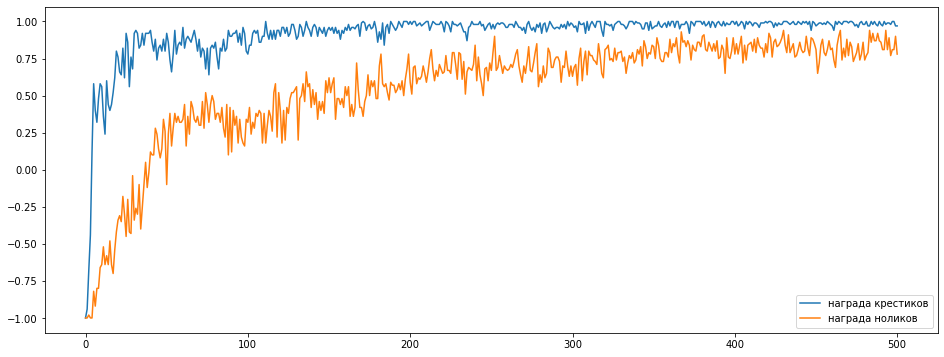

In [390]:
plt.figure(figsize=(16, 6))
plt.plot(rewards33[:, 0], label='награда крестиков')
plt.plot(rewards33[:, 1], label='награда ноликов')
plt.legend();

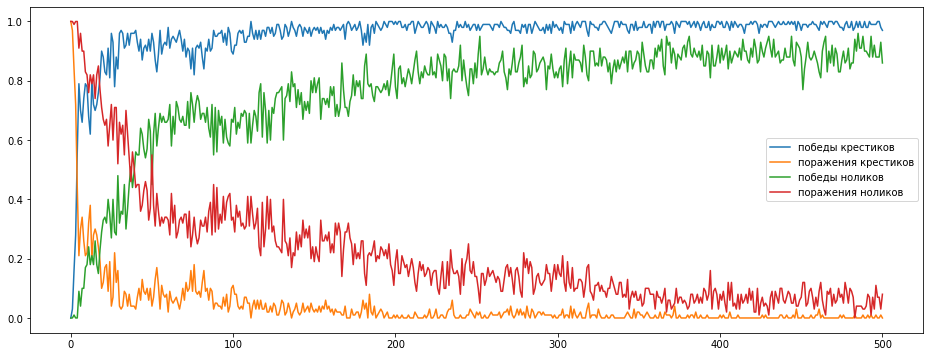

In [391]:
n = 100
plt.figure(figsize=(16, 6))
plt.plot(wins[:, 0] / n, label='победы крестиков')
plt.plot(losses[:, 0] / n, label='поражения крестиков')
plt.plot(wins[:, 1] / n, label='победы ноликов')
plt.plot(losses[:, 1] / n, label='поражения ноликов')
plt.legend();

В целом, получились неплохие стратегии. Попробуем 4x4.

In [392]:
net = DQN(env44, Network44)

rewards44, wins, losses, draws, net = evaluate_reward(
    net, n_episodes_train=50000, n_episodes_eval=100, eval_every=100)

rewards44 = np.array(rewards44)
wins = np.array(wins)
losses = np.array(losses)
draws = np.array(draws)

100%|██████████| 50000/50000 [17:17<00:00, 48.20it/s]


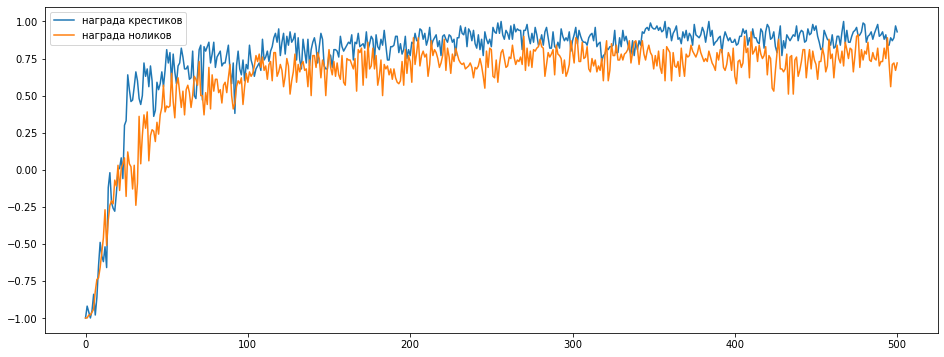

In [393]:
plt.figure(figsize=(16, 6))
plt.plot(rewards44[:, 0], label='награда крестиков')
plt.plot(rewards44[:, 1], label='награда ноликов')
plt.legend();

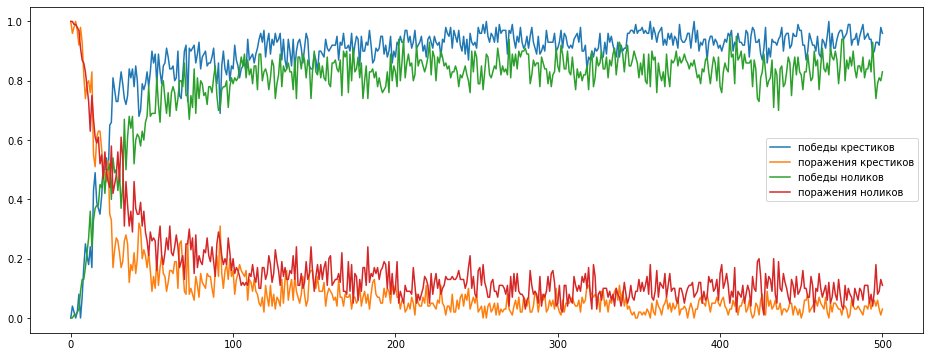

In [394]:
n = 100
plt.figure(figsize=(16, 6))
plt.plot(wins[:, 0] / n, label='победы крестиков')
plt.plot(losses[:, 0] / n, label='поражения крестиков')
plt.plot(wins[:, 1] / n, label='победы ноликов')
plt.plot(losses[:, 1] / n, label='поражения ноликов')
plt.legend();

Видим, что 4x4 уже получилось обучить лучше, чем при табличном Q обучении и при этом даже быстрее. Реализуем Dueling DQN.

In [395]:
class DuelNetwork33(Network33):
    def __init__(self, layer_size=512):
        super().__init__()
        self.l1 = nn.Conv2d(3, layer_size, 3)
        self.l2 = nn.Linear(layer_size, layer_size)
        self.v = nn.Linear(layer_size, 1)
        self.a = nn.Linear(layer_size, 9)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.l2(x))
        v = self.v(x)
        a = self.a(x)
        q = v + (a - a.mean(1, keepdim=True))
        return q
    
class DuelNetwork44(Network44):
    def __init__(self, layer_size=512):
        super().__init__()
        self.l1 = nn.Conv2d(3, layer_size, 3)
        self.l2 = nn.Linear(layer_size * 4, layer_size)
        self.v = nn.Linear(layer_size, 1)
        self.a = nn.Linear(layer_size, 16)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.l2(x))
        v = self.v(x)
        a = self.a(x)
        q = v + (a - a.mean(1, keepdim=True))
        return q

Обучим 3х3

In [396]:
net = DQN(env33, DuelNetwork33, batch_size=512)

rewards33, wins, losses, draws, net = evaluate_reward(
    net, n_episodes_train=50000, n_episodes_eval=100, eval_every=100)

rewards33 = np.array(rewards33)
wins = np.array(wins)
losses = np.array(losses)
draws = np.array(draws)

100%|██████████| 50000/50000 [13:44<00:00, 60.63it/s]


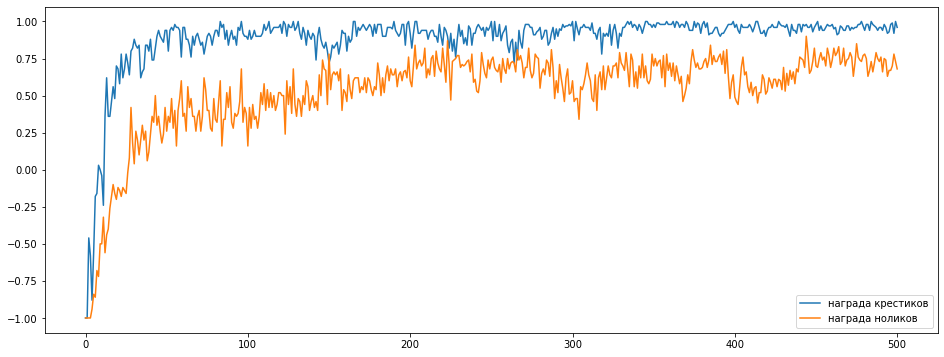

In [397]:
plt.figure(figsize=(16, 6))
plt.plot(rewards33[:, 0], label='награда крестиков')
plt.plot(rewards33[:, 1], label='награда ноликов')
plt.legend();

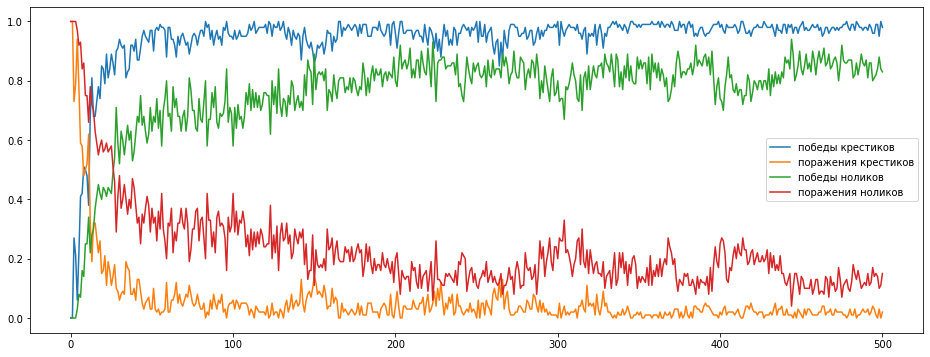

In [398]:
n = 100
plt.figure(figsize=(16, 6))
plt.plot(wins[:, 0] / n, label='победы крестиков')
plt.plot(losses[:, 0] / n, label='поражения крестиков')
plt.plot(wins[:, 1] / n, label='победы ноликов')
plt.plot(losses[:, 1] / n, label='поражения ноликов')
plt.legend();

Обучим 4х4

In [399]:
net = DQN(env44, DuelNetwork44, batch_size=512)

rewards44, wins, losses, draws, net = evaluate_reward(
    net, n_episodes_train=30000, n_episodes_eval=100, eval_every=100)

rewards44 = np.array(rewards44)
wins = np.array(wins)
losses = np.array(losses)
draws = np.array(draws)

100%|██████████| 30000/30000 [13:24<00:00, 37.27it/s]


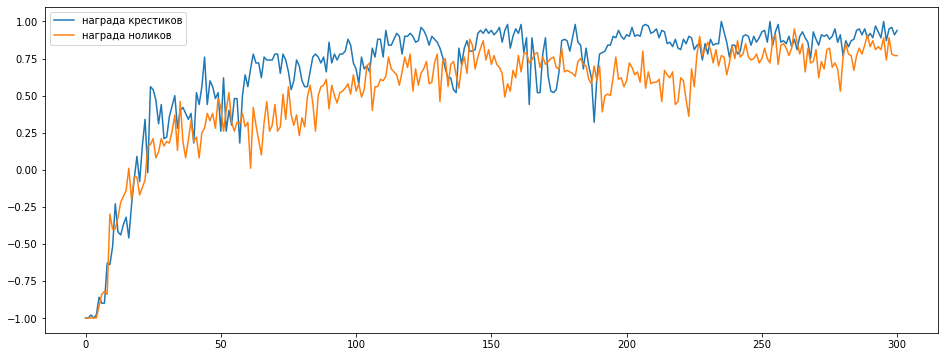

In [400]:
plt.figure(figsize=(16, 6))
plt.plot(rewards44[:, 0], label='награда крестиков')
plt.plot(rewards44[:, 1], label='награда ноликов')
plt.legend();

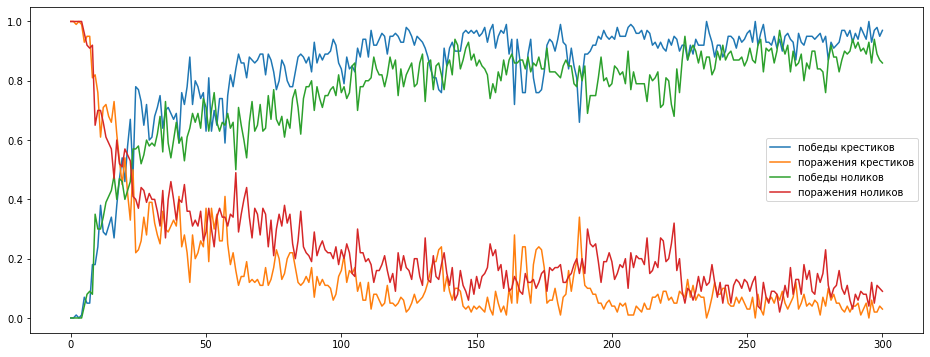

In [401]:
n = 100
plt.figure(figsize=(16, 6))
plt.plot(wins[:, 0] / n, label='победы крестиков')
plt.plot(losses[:, 0] / n, label='поражения крестиков')
plt.plot(wins[:, 1] / n, label='победы ноликов')
plt.plot(losses[:, 1] / n, label='поражения ноликов')
plt.legend();

# Часть третья: расширим и углубим поиск

Крестики-нолики -- это, конечно, далеко не го, и обычный альфа-бета поиск с отсечением здесь наверняка может работать идеально вплоть до довольно больших досок. Однако мы всё-таки для этого учебного задания будем реализовывать более практически релевантный метод MCTS -- заодно фактически получится и упражнение на многоруких бандитов.
- Реализуйте rollouts со случайной стратегией и (опционально) rollouts с неслучайной, но простой стратегией (например, основанной на дополнении нескольких паттернов или на Q-функции, которая у вас получилась в первом пункте).
- Реализуйте MCTS-поиск с этими rollouts для крестиков-ноликов на досках разного размера, сравните полученные стратегии между собой и со стратегиями, обученными в первых двух частях.

In [215]:
def rollout(env):
    roll_env = deepcopy(env)
    s, empty_spaces, turn = roll_env.getState()
    done = False
    while not done:
        a_idx = np.random.randint(len(empty_spaces))
        a = empty_spaces[a_idx]
        (s, empty_spaces, _), r, done, _ = roll_env.step(a) 
    return - r * turn

def evaluate_rollout(env, empty_spaces, n_rollouts=50, crosses=True):
    best_a_idx = None
    best_q = - np.inf
    for a_idx in range(len(empty_spaces)):
        next_env = deepcopy(env)
        a = empty_spaces[a_idx]
        _ , r, done, _ = next_env.step(a) 
        if not done:
            q = np.mean([rollout(next_env) for _ in range(n_rollouts)])
        else:
            q = r if crosses else -r
        if q > best_q:
            best_q = q
            best_a_idx = a_idx
    return best_a_idx

def play_by_rollout(env, n_rollouts=50, crosses=True):
    # играем против случайной стратегии
    rewards = []
    s, empty_spaces, cur_turn = env.reset()
    done = False
    while not done:
        # мы играем за тех, чей ход
        if (cur_turn == 1 and crosses) or (cur_turn == -1 and not crosses):
            a_idx = evaluate_rollout(env, empty_spaces, n_rollouts, crosses)
        else:
            a_idx = np.random.randint(len(empty_spaces))
        a = empty_spaces[a_idx]
        (s, empty_spaces, cur_turn), r, done, _ = env.step(a) 
    
    if r == -10: # только мы сами могли так плохо сходить
        raise ValueError('Impossible!')
    rewards.append(r if crosses else -r)
    return rewards

def evaluate_reward_by_rollouts(env, n_episodes, n_rollouts=50):
    rewards = []
    for i in tqdm(range(n_episodes)):
        rewards_c = play_by_rollout(env, n_rollouts)
        rewards_n = play_by_rollout(env, n_rollouts, crosses=False)
        rewards.append((np.mean(rewards_c), np.mean(rewards_n)))
    rewards = np.array(rewards)
    print(f"""Стратегия крестиков: награда={rewards[:, 0].mean()}, побед={(rewards[:, 0] == 1).mean()},
    поражений={(rewards[:, 0] == -1).mean()}, ничьих={(rewards[:, 0] == 0).mean()}""")
    print(f"""Стратегия ноликов: награда={rewards[:, 1].mean()}, побед={(rewards[:, 1] == 1).mean()}, 
    поражений={(rewards[:, 1] == -1).mean()}, ничьих={(rewards[:, 1] == 0).mean()}""")
    return rewards

In [216]:
rewards33 = evaluate_reward_by_rollouts(env33, 2000, 50)

100%|██████████| 2000/2000 [16:22<00:00,  2.03it/s]

Стратегия крестиков: награда=0.9865, побед=0.9865,
    поражений=0.0, ничьих=0.0135
Стратегия ноликов: награда=0.8435, побед=0.886, 
    поражений=0.0425, ничьих=0.0715


In [217]:
rewards44 = evaluate_reward_by_rollouts(env44, 2000, 50)

100%|██████████| 2000/2000 [1:58:40<00:00,  3.56s/it]  

Стратегия крестиков: награда=0.966, побед=0.9665,
    поражений=0.0005, ничьих=0.033
Стратегия ноликов: награда=0.9145, побед=0.915, 
    поражений=0.0005, ничьих=0.0845


Как мы видим, с помощью rollouts удалось очень неплохо играть. Попробуем скрестить их с MCTS.

In [727]:
class MCTS:
    def __init__(self, env, C=np.sqrt(2), player=None):
        self.env = env
        self.tree = {}
        self.rewards = defaultdict(int)
        self.visits = defaultdict(int)
        self.C = C
        self.player = player
            
    def get_action(self, node1, node2):
        return np.argwhere(
            np.array(list(node1)).reshape(self.env.n_rows, self.env.n_cols) 
            != np.array(list(node2)).reshape(self.env.n_rows, self.env.n_cols)
        ).ravel()
             
    def select_by_uct(self, node):
        N = np.log(self.visits[node])
        uct = []
        for child in self.tree[node]:
            uct.append(self.rewards[child] / self.visits[child] + self.C * np.sqrt(N / self.visits[child]))
        return self.tree[node][np.argmax(uct)]
        
    def select_node(self, node):
        path = []
        while True:
            path.append(node)
            if node not in self.tree or not self.tree[node]: # еще не посещали либо терминальная
                return path
            for child in self.tree[node]:
                if child not in self.visits: # выбираем первого непосещенного ребенка
                    a = self.get_action(node, child)
                    path.append(child)
                    self.env.step(a)
                    return path
            if self.player is None or (self.player == self.env.curTurn):
                child = self.select_by_uct(node) # идем дальше по алгоритму UCT   
                a = self.get_action(node, child)
            else:
                empty_spaces = self.env.getEmptySpaces()
                a_idx = np.random.randint(len(empty_spaces))
                a = empty_spaces[a_idx]
            (node, _, _), _, _, _ = self.env.step(a)
    
    def expand(self):
        node, empty_spaces, cur_turn = self.env.getState()
        if node in self.tree:
            return
        children = []
        if not self.env.gameOver:
            for a in empty_spaces:
                self.env.makeMove(cur_turn, a[0], a[1])
                children.append(self.env.getHash())
                self.env.makeMove(0, a[0], a[1])

        self.tree[node] = children
            
    def rollout(self):
        if self.env.gameOver:
            self.env.curTurn = -self.env.curTurn
            r = self.env.isTerminal()
            return int(r * self.env.curTurn > 0), True
         
        env = deepcopy(self.env)
        _, empty_spaces, turn = env.getState()
        done = False
        while not done:
            a_idx = np.random.randint(len(empty_spaces))
            a = empty_spaces[a_idx]
            (_, empty_spaces, _), r, done, _ = env.step(a) 
            
        if turn == 1: 
            if r >= 0:
                return 0, False
            return 1, False
        if turn == -1: 
            if r <= 0:
                return 0, False
            return 1, False
            
    def backprop(self, path, reward):
        for node in reversed(path):
            self.visits[node] += 1
            self.rewards[node] += reward
            reward = 1 - reward
      
    def train_episode(self):
        node, _, _ = self.env.reset()
        done = False
        path = []
        while not done:
            node, _, _ = self.env.getState()
            cur_path = self.select_node(node)
            path += cur_path
            self.expand()
            reward, done = self.rollout()
            self.backprop(path, reward)
            path = path[:-1]
        
    def select_best_action(self):
        node, empty_spaces, _ = self.env.getState()
        if node not in self.tree:
            a_idx = np.random.randint(len(empty_spaces))
        else:
            q = []
            for child in self.tree[node]:
                if child not in self.visits:
                    q.append(-np.inf)
                else:
                    q.append(self.rewards[child] / self.visits[child])
            a_idx = np.argmax(q)
        return a_idx
    
    
def play_by_mcts(tree, n_episodes=500_000, crosses=True):
    # играем против случайной стратегии
    wins = 0
    losses = 0
    draws = 0
    rewards = []
    for _ in range(n_episodes):
        s, empty_spaces, cur_turn = tree.env.reset()
        done = False
        while not done:
            # мы играем за тех, чей ход
            if ((cur_turn == 1 and crosses) or (cur_turn == -1 and not crosses)):
                a_idx = tree.select_best_action()
            else:
                a_idx = np.random.randint(len(empty_spaces))
            a = empty_spaces[a_idx]
            (s, empty_spaces, cur_turn), r, done, _ = tree.env.step(a) 
        
        if r == -10:
            raise ValueError('Impossible!')
        elif r == 0:
            reward = r
            draws += 1
        else:
            reward = r if crosses else -r
            if reward == 1:
                wins += 1
            else:
                losses += 1

        rewards.append(reward)
    return rewards, wins, losses, draws

def evaluate_reward_by_mcts(tree, n_episodes_train=30000, n_episodes_eval=100, eval_every=100):
    rewards = []
    wins = []
    losses = []
    draws = []
    for i in tqdm(range(n_episodes_train)):
        if i == 0 or (i + 1) % eval_every == 0:
            rewards_c, wins_c, losses_c, draws_c = play_by_mcts(tree, n_episodes_eval)
            rewards_n, wins_n, losses_n, draws_n = play_by_mcts(tree, n_episodes_eval, crosses=False)
            rewards.append((np.mean(rewards_c), np.mean(rewards_n)))
            wins.append((wins_c, wins_n))
            losses.append((losses_c, losses_n))
            draws.append((draws_c, draws_n))
        tree.train_episode()       
    return np.array(rewards), np.array(wins), np.array(losses), np.array(draws), tree

In [730]:
tree33 = MCTS(env33)

rewards33, wins, losses, draws, tree33 = evaluate_reward_by_mcts(tree33)

100%|██████████| 30000/30000 [00:44<00:00, 675.27it/s]


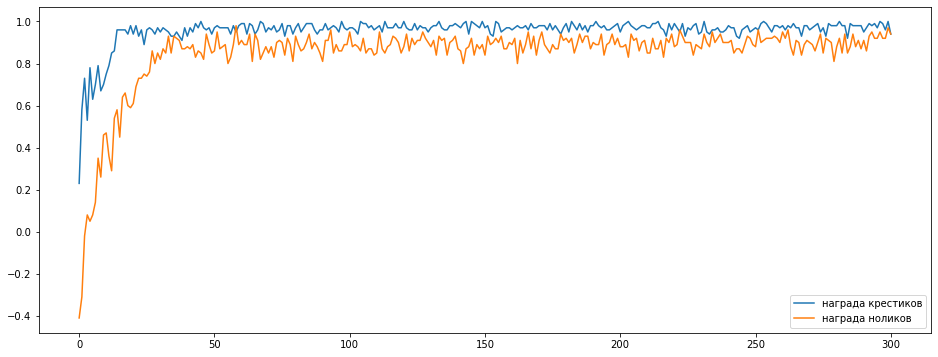

In [703]:
plt.figure(figsize=(16, 6))
plt.plot(rewards33[:, 0], label='награда крестиков')
plt.plot(rewards33[:, 1], label='награда ноликов')
plt.legend();

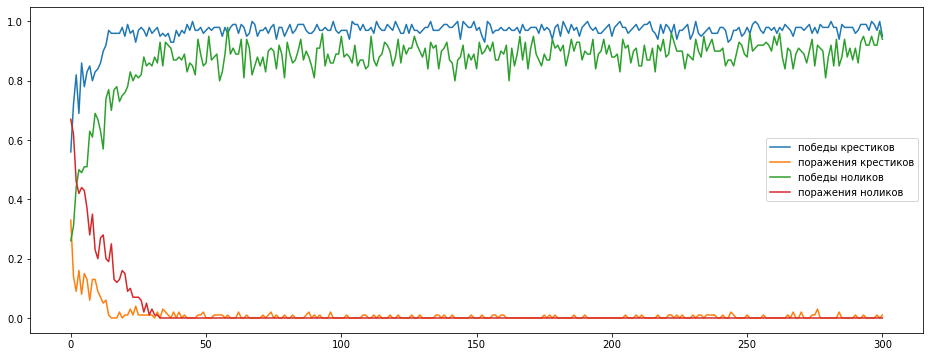

In [704]:
n = 100
plt.figure(figsize=(16, 6))
plt.plot(wins[:, 0] / n, label='победы крестиков')
plt.plot(losses[:, 0] / n, label='поражения крестиков')
plt.plot(wins[:, 1] / n, label='победы ноликов')
plt.plot(losses[:, 1] / n, label='поражения ноликов')
plt.legend();

3x3 очень хорошо и невероятно быстро!

In [ ]:
tree44_noughts = MCTS(env44, player=-1)

rewards44, wins, losses, draws, tree44_noughts = evaluate_reward_by_mcts(
    tree44_noughts, n_episodes_train=1_000_000, n_episodes_eval=2000, eval_every=5000)

  1%|          | 11749/1000000 [01:43<2:04:37, 132.17it/s]

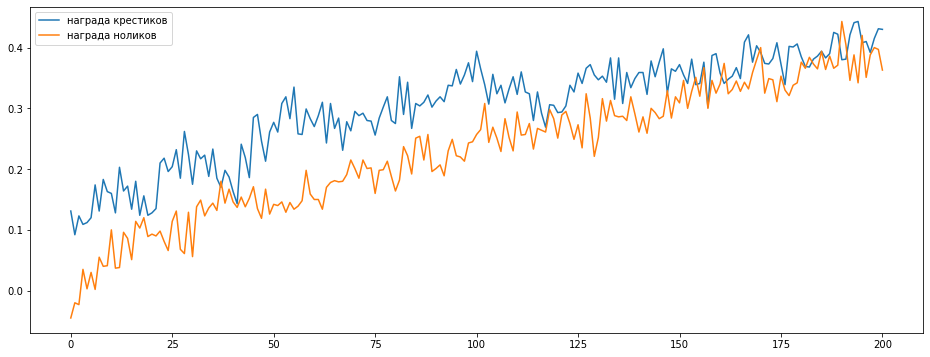

In [700]:
plt.figure(figsize=(16, 6))
plt.plot(rewards44[:, 0], label='награда крестиков')
plt.plot(rewards44[:, 1], label='награда ноликов')
plt.legend();

In [680]:
tree44 = MCTS(env44, C=5)

rewards44, wins, losses, draws, tree44 = evaluate_reward_by_mcts(
    tree44, n_episodes_train=2_000_000, n_episodes_eval=1000, eval_every=1000)

100%|██████████| 2000000/2000000 [2:24:34<00:00, 230.56it/s]  


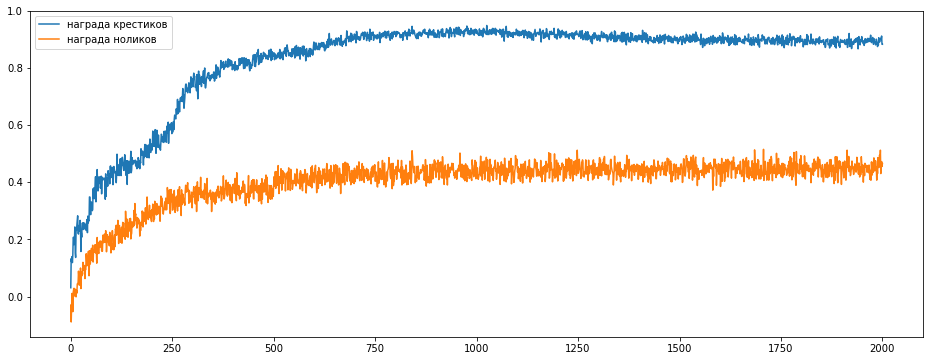

In [681]:
plt.figure(figsize=(16, 6))
plt.plot(rewards44[:, 0], label='награда крестиков')
plt.plot(rewards44[:, 1], label='награда ноликов')
plt.legend();

4x4 несколько похуже и подольше, что ожидаемо. Крестики учатся быстро (если оставить стандартный C = sqrt(2)), а вот нолики, играя против сильных крестиков, начинают отставать. Я специально добавил больше exploration, чтобы разрыв был не таким серьезным. У меня есть ощущение, что если обучать все против случайных стратегий, то будет лучше.